In [32]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import warnings

In [2]:
#read the experimental data
data = pd.read_csv("data.csv")
display(data)

#Define the time range
t = data.iloc[:,0]

#Define experimental concentration data
Xexp = data.iloc[:,1]
Sexp = data.iloc[:,2]
Pexp = data.iloc[:,3]

,t(h),X,S,P
0,0,1.70,91.45,0.87
1,1,1.65,89.74,1.77
2,2,1.85,87.94,2.03
3,3,2.80,81.84,4.05
4,4,2.65,74.64,8.18
5,5,3.35,65.85,12.80
6,6,3.30,55.23,15.38
7,7,5.05,45.54,21.10
8,8,4.17,37.96,28.06
9,9,3.90,28.66,33.22


This code reads in a csv file called "data.csv" using the pd.read_csv() function from the pandas library. The display(data) function is used to display the contents of the dataframe to the console for easy inspection.

Once the data is loaded into the dataframe, the code defines the time range using the t = data.iloc[:,0] command, this is selecting the first column of the dataframe and assigns it to the variable t.

Then, the code defines the experimental concentration data for each variable (X, S, P) by selecting the appropriate columns of the dataframe (Xexp = data.iloc[:,1], Sexp = data.iloc[:,2], Pexp = data.iloc[:,3]). These variables will be used later in the code to fit the model to the data and plot the results.

In [3]:
def monod(z,t,paras):
    """_System of equations used to describe the kinetics of fermentation (Monod)_

    Args:
        z (_): vector
        t (_array_): time
        paras (_dict_): kinetic parameters

    Returns:
        _array_: differencials of X, S, and P over time_
    """
   
    #Conversion parameters (experimental)
    Yxs = 0.0434
    Yps = 0.5078
    Ypx = Yps/Yxs

    #Assign each variable to a vector z
    X = z[0]
    S = z[1]
    P = z[2]

    #Define the parameters to adjust
    try:
        umax = paras['umax'].value
        Ks   = paras['Ks'].value

    except KeyError:
        umax, Ks = paras

    #Define the ODE system
    dXdt = umax*S/(Ks+S)*X
    dSdt = -umax*S/(Ks+S)*X/Yxs
    dPdt = umax*S/(Ks+S)*X*Ypx
   
    return [dXdt,dSdt,dPdt]

This code defines a function called monod which takes three inputs: a vector z, an array t, and a dictionary of parameters paras. The function uses the Monod kinetics equation to describe the kinetics of fermentation.

The function starts by defining some conversion parameters (Yxs, Yps, and Ypx) that are used in the Monod equation. It then assigns the variables X, S, and P to the values in the vector z. The function then defines the kinetic parameters (umax and Ks) that are used in the Monod equation. These parameters are either taken from the dictionary paras or passed directly as variables.

The function then defines the system of ODEs (ordinary differential equations) that describe the change in concentration of X, S, and P over time. These equations are based on the Monod equation, and use the values of the kinetic parameters and conversion parameters that were defined earlier.

Finally, the function returns the time derivatives of X, S, and P, which can be used to simulate the kinetics of fermentation using numerical integration methods.

In [4]:
def solver(t,x0,paras):
    """_solve the differential equations from the model_

    Args:
        t (_array_): time
        x0 (_list_): initial values of X, S, and P
        paras (_dict_): kinetic parameters

    Returns:
        _array_: solutions of X, S, and P
    """
    x = odeint(monod,x0,t,args=(paras,))
    return x

This code defines a function called solver which takes three inputs: an array of time points t, a list of initial values for the concentrations of X, S, and P x0, and a dictionary of kinetic parameters paras.

The function uses the odeint function from the scipy.integrate library to solve the system of differential equations defined by the monod function. The odeint function takes the following inputs:

The name of the function that defines the system of differential equations (monod)
The initial conditions for the concentrations of X, S, and P (x0)
The array of time points for which to solve the equations (t)
The additional arguments to pass to the function (paras)
The function returns the solutions of X, S, and P as an array. These solutions can be used to plot the kinetics of fermentation or to extract other information.

In [5]:
def objFun(paras,t,Xexp,Sexp,Pexp):
    """_objective function using experimental data from X, S, and P_

    Args:
        paras (_dict_): kinetic parameters
        t (_array_): time
        Xexp (_array_): Experimental yeast concentration
        Sexp (_array_): Experimental substrate concentration
        Pexp (_array_): Experimental ethanol concentration
        
    Returns:
        _array_: result of objective function
    """
    x0 = paras['X0'].value, paras['S0'].value, paras['P0'].value
    model = solver(t,x0,paras)
    X_model = model[:, 0]
    S_model = model[:, 1]
    P_model = model[:, 2]
    return (((X_model-Xexp)**2 + (P_model-Pexp)**2 + (S_model-Sexp)**2)**0.5).ravel()

This code defines a function called objFun which takes four inputs: a dictionary of kinetic parameters paras, an array of time points t, an array of experimental yeast concentrations Xexp, an array of experimental substrate concentrations Sexp, and an array of experimental ethanol concentrations Pexp.

The function uses these inputs to simulate the kinetics of fermentation using the solver function, with the kinetic parameters from paras and the initial concentrations from the paras dictionary. It then calculates the difference between the simulated concentrations of X, S, and P, and the experimental concentrations of X, S, and P. The function returns this difference, squared and sum of them, and then return the square root of the sum as a single value, using the ravel() function to flatten the array.

This function is often used as the objective function in optimization algorithms, the goal is to minimize the difference between the simulated and experimental data. The objective function is used to evaluate the performance of the model and the goodness of fit of the kinetic parameters.

In [6]:
#Define initial conditions
X0 = data.iloc[0,1]
S0 = data.iloc[0,2]
P0 = data.iloc[0,3]
init = [X0, S0, P0]

#Set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('X0', value=X0, vary=False)
params.add('S0', value=S0, vary=False)
params.add('P0', value=P0, vary=False)
params.add('umax', value=0.5, min=0, max=1)
params.add('Ks', value=0.5, min=0, max=5)

#Minimize the objective function optimizing "params"
result = minimize(objFun, params, args=(t, Xexp, Sexp, Pexp), method='leastsq')

# results of the optimal fit at experimental time 
fitted = solver(t, init, result.params)
Xopt = fitted[:,0]
Sopt = fitted[:,1]
Popt = fitted[:,2]

# display fitted statistics
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 13
    # variables        = 2
    chi-square         = 170.946701
    reduced chi-square = 15.5406092
    Akaike info crit   = 37.4932320
    Bayesian info crit = 38.6231307
[[Variables]]
    X0:    1.7 (fixed)
    S0:    91.45 (fixed)
    P0:    0.87 (fixed)
    umax:  0.10621926 +/- 0.00913593 (8.60%) (init = 0.5)
    Ks:    0.47918683 +/- 4.34690297 (907.14%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(umax, Ks) = 0.979


This code sets the initial conditions for the concentrations of yeast, substrate, and ethanol using data from a dataframe data. Then it defines a params object using the Parameters class from the lmfit library. The object includes the initial concentrations of X, S, and P, as well as two kinetic parameters (umax and Ks) that are allowed to vary during the optimization. The min and max attributes are set for the kinetic parameters to define the range of values that they can take.

The minimize function from lmfit is then used to minimize the objective function defined in objFun by varying the kinetic parameters in params to best fit the experimental data. The leastsq method is used for the optimization algorithm. The args attribute is used to pass the time points, experimental yeast concentrations, experimental substrate concentrations, and experimental ethanol concentrations to the objective function.

Finally, the code uses the solver function to simulate the kinetics of fermentation with the optimal values of the kinetic parameters and the initial concentrations. The resulting solutions are stored in Xopt, Sopt, and Popt. The report_fit function is used to print out a report of the fit, including the optimal values of the parameters, the residuals and goodness of fit.

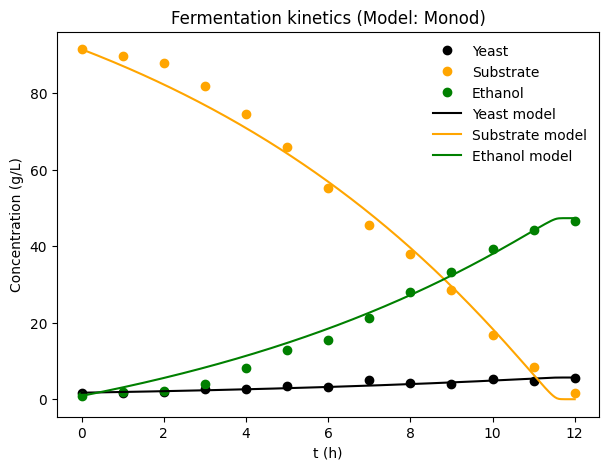

In [7]:
# results of the optimal fit in arbritary time 
t2 = np.linspace(0, max(t),250)
fitted2 = solver(t2, init, result.params)
Xopt2 = fitted2[:,0]
Sopt2 = fitted2[:,1]
Popt2 = fitted2[:,2]

plt.figure(0, figsize=(7, 5))
#Experimental points
plt.plot(t, Xexp, 'o', color='black', label = 'Yeast')
plt.plot(t, Sexp, 'o', color='orange',label = 'Substrate')
plt.plot(t, Pexp, 'o', color='green', label = 'Ethanol')

#ODE system model
plt.plot(t2, Xopt2,'-', color='black', label = 'Yeast model')
plt.plot(t2, Sopt2,'-', color='orange',label = 'Substrate model')
plt.plot(t2, Popt2,'-', color='green', label = 'Ethanol model')

#Graphic parameters
plt.title('Fermentation kinetics (Model: Monod)')
plt.xlabel('t (h)')
plt.ylabel('Concentration (g/L)')
plt.legend(loc='best', frameon=False)

This code generates a plot that compares the experimental data for yeast, substrate, and ethanol concentrations with the results of a model simulation of the same data using the Monod kinetics equation. The model parameters were optimized to fit the experimental data. The x-axis represents time in hours and the y-axis represents concentration in grams per liter. The plot includes data points for the experimental measurements, as well as lines for the modeled concentrations of yeast, substrate, and ethanol. The plot also includes a title, x-axis label, y-axis label, and a legend to indicate which line corresponds to which data.

Text(0.5, 1.0, 'Ethanol')

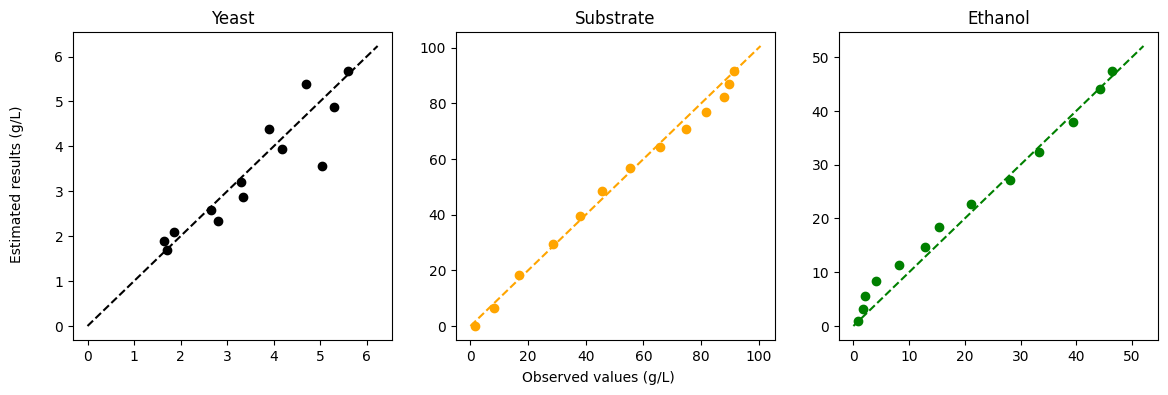

In [8]:
#Estimated vs. observed plots
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.text(0.5, 0.005, 'Observed values (g/L)', ha='center')
fig.text(0.08, 0.5, 'Estimated results (g/L)', va='center', rotation='vertical')

axs[0].plot(Xexp, Xopt, 'o', color='black')
axs[0].plot([0,max(Xopt)*1.1], [0,max(Xopt)*1.1], '--', color='black')
axs[0].set_title('Yeast')

axs[1].plot(Sexp, Sopt, 'o', color='orange')
axs[1].plot([0,max(Sopt)*1.1], [0,max(Sopt)*1.1], '--', color='orange')
axs[1].set_title('Substrate')

axs[2].plot(Pexp, Popt, 'o', color='green')
axs[2].plot([0,max(Popt)*1.1], [0,max(Popt)*1.1], '--', color='green')
axs[2].set_title('Ethanol')


This code generates a figure with three subplots. Each subplot shows a scatter plot of the estimated results (Xopt, Sopt, Popt) against the observed values (Xexp, Sexp, Pexp) for yeast, substrate, and ethanol, respectively. The subplots are created using the plt.subplots() function from matplotlib. The first subplot corresponds to yeast, the second to substrate and the third to ethanol. Each subplot contains a scatter plot of the estimated results against the observed values, as well as a line of equality (y=x) to show the perfect prediction.

The title of each subplot corresponds to the variable being plotted, and the x and y axis are labeled. Additionally, the figure title and the x and y labels are set with the fig.text() and axs[i].set_title() methods respectively.

This plot can be used to evaluate the performance of the model and the goodness of fit of the kinetic parameters. If the points are distributed around the line of equality, the model is considered to have a good fit.

In [9]:
#Statistics
print("X: R² = {:.3f}".format(r2_score(Xexp,Xopt))) 
print("S: R² = {:.3f}".format(r2_score(Sexp,Sopt)))
print("P: R² = {:.3f}".format(r2_score(Pexp,Popt)))

X: R² = 0.835
S: R² = 0.991
P: R² = 0.982


In [10]:
#Specify the confidence level
alfa = 0.05

#Calculate the residues and test normality
resX = Xexp - Xopt
hX = stats.shapiro(resX)
if hX[1] < alfa:
    print('The residues of X are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hX[1],alfa))
else:
    print('The residues of X are normally distributed. p-value = {:.3f} > {:.2f}'.format(hX[1],alfa))

resS = Sexp - Sopt
hS = stats.shapiro(resS)
if hS[1] < alfa:
    print('The residues of S are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hS[1],alfa))
else:
    print('The residues of S are normally distributed. p-value = {:.3f} > {:.2f}'.format(hS[1],alfa))

resP = Pexp - Popt
hP = stats.shapiro(resP)
if hP[1] < alfa:
    print('The residues of P are not normally distributed. p-value = {:.3f} < {:.2f}'.format(hP[1],alfa))
else:
    print('The residues of P are normally distributed. p-value = {:.3f} > {:.2f}'.format(hP[1],alfa))


The residues of X are normally distributed. p-value = 0.233 > 0.05
The residues of S are normally distributed. p-value = 0.598 > 0.05
The residues of P are normally distributed. p-value = 0.513 > 0.05


This code performs a normality test on the residues (differences between the observed and estimated values) for each variable (X, S, and P). The normality test is done using the shapiro() function from the scipy.stats library, which returns a test statistic and a p-value.

The code starts by specifying a significance level (alfa) of 0.05, which is commonly used in statistical tests. Then, it calculates the residues for each variable by subtracting the estimated results (Xopt, Sopt, Popt) from the observed values (Xexp, Sexp, Pexp).

The shapiro() function is applied to the residues, and the p-value is compared to the significance level. If the p-value is less than the significance level, it suggests that the residues are not normally distributed, and a message is printed to indicate this. If the p-value is greater than the significance level, it suggests that the residues are normally distributed and a message is printed to indicate this.

The normality test is important to ensure that the assumptions of the statistical tests are met. If the assumptions are not met, the results of the statistical tests may be unreliable.

Text(0, 0.5, '')

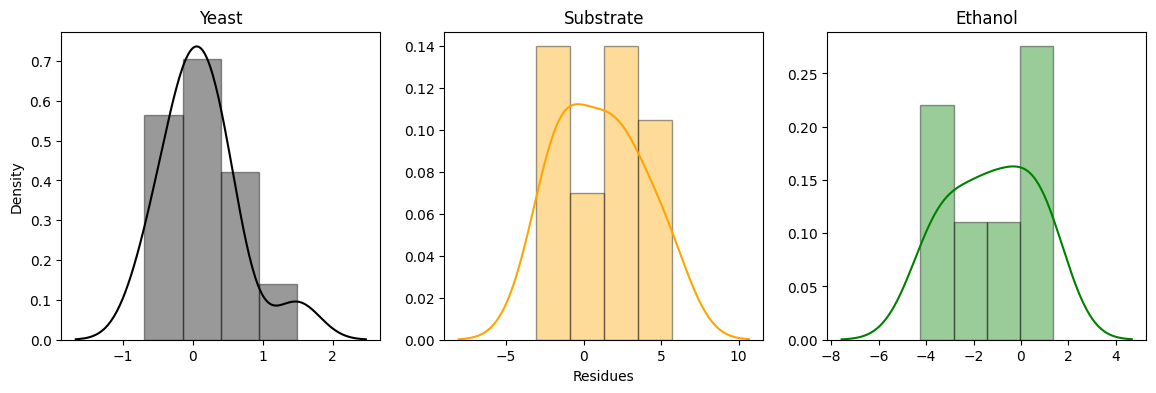

In [11]:
#Histogram residues
warnings.filterwarnings('ignore')
f = plt.figure(2, figsize=(14,4))

f.add_subplot(1,3,1)
sns.distplot(resX, hist = True, kde = True, bins = 4, color = 'black', hist_kws={'edgecolor': 'black'})
plt.title("Yeast")
plt.xlabel("") 
plt.ylabel("Density") 

f.add_subplot(1,3,2)
sns.distplot(resS, hist = True, kde = True, bins = 4, color = 'orange', hist_kws={'edgecolor': 'black'})
plt.title("Substrate")
plt.xlabel("Residues") 
plt.ylabel("")

f.add_subplot(1,3,3)
sns.distplot(resP, hist = True, kde = True, bins = 4, color = 'green', hist_kws={'edgecolor': 'black'})
plt.title("Ethanol")
plt.xlabel("") 
plt.ylabel("")

This code generates a figure with three subplots, one for each variable (X, S, and P). Each subplot shows a histogram of the residues (differences between the observed and estimated values) for the corresponding variable.

The subplots are created using the sns.distplot() function from the seaborn library, which is a wrapper around the hist() and kdeplot() functions from matplotlib and creates a histogram with a kernel density estimate (KDE) line. The color of the histogram and KDE line is set to black for yeast, orange for substrate and green for ethanol.

The title, x-label, and y-label of each subplot are set to indicate the variable being plotted and the x and y axis are labeled. The plt.xlabel("") and plt.ylabel("") are used to remove the labels when they are not needed.

This plot can be used to evaluate the distribution of the residues and check for outliers, skewness, and kurtosis. If the residues are normally distributed, it suggests that the model is appropriate for the data and that the kinetic parameters are accurately estimated.

Text(0.5, 1.0, 'Ethanol')

<Figure size 640x480 with 0 Axes>

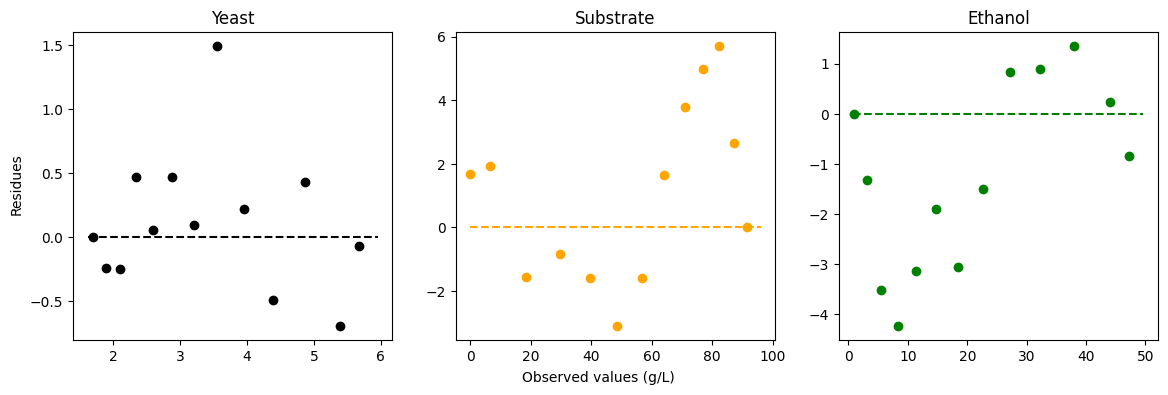

In [12]:
#Residues vs. estimated plots
plt.figure(3)
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
fig.text(0.5, 0.005, 'Observed values (g/L)', ha='center')
fig.text(0.08, 0.5, 'Residues', va='center', rotation='vertical')


axs[0].plot(Xopt,resX, 'o', color='black')
axs[0].plot([min(Xopt)*0.95, max(Xopt)*1.05], [0,0], '--', color='black')
axs[0].set_title('Yeast')

axs[1].plot(Sopt,resS, 'o', color='orange')
axs[1].plot([min(Sopt)*0.95,max(Sopt)*1.05], [0,0], '--', color='orange')
axs[1].set_title('Substrate') 

axs[2].plot(Popt,resP, 'o', color='green')
axs[2].plot([min(Popt)*0.95,max(Popt)*1.05], [0,0], '--', color='green')
axs[2].set_title('Ethanol')


This code generates a figure with three subplots, one for each variable (X, S, and P). Each subplot shows a scatter plot of the observed values (Xexp, Sexp, Pexp) against the residues (differences between the observed and estimated values) for the corresponding variable.

The subplots are created using the plt.subplots() function from matplotlib, the plot() function is used to create a scatter plot of the observed values against the residues. The color of the point is set to black for yeast, orange for substrate and green for ethanol. The plot([min(Xopt)*0.95, max(Xopt)*1.05], [0,0], '--', color='black') is used to add a line of y =0 to show the perfect prediction.

The title, x-label, and y-label of each subplot are set to indicate the variable being plotted and the x and y axis are labeled. Additionally, the figure title and the x and y labels are set with the fig.text() and axs[i].set_title() methods respectively.

This plot can be used to evaluate the linearity of the model and the independence of the errors. If the points are randomly scattered around the line of y=0, the model is considered to have a good fit and the errors are independent.

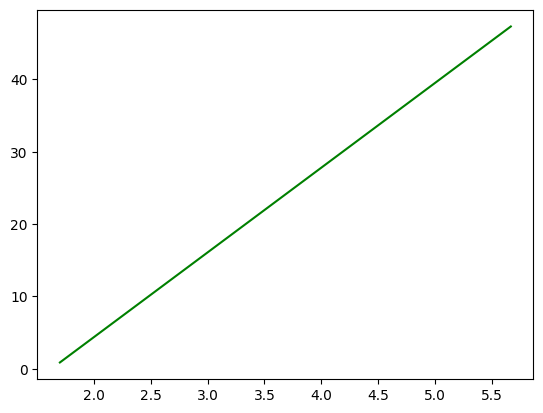

In [15]:
#plt.plot(Sopt2, Xopt2,'-', color='black')
#plt.plot(Sopt2,Popt2,'-', color='orange',label = 'Substrate model')
plt.plot(Xopt2, Popt2,'-', color='green', label = 'Ethanol model')

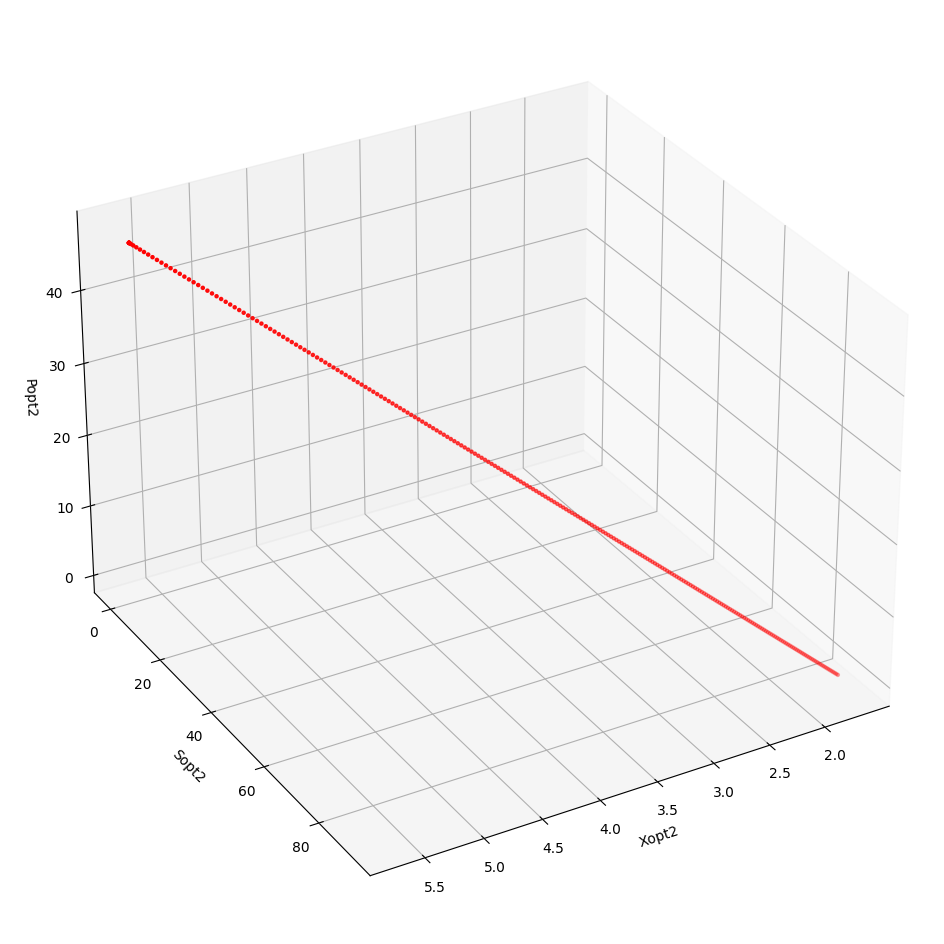

In [34]:


# create 3D figure
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

# plot the points
ax.scatter(Xopt2, Sopt2, Popt2, color='r', marker='.')

# set axis labels
ax.set_xlabel('Xopt2')
ax.set_ylabel('Sopt2')
ax.set_zlabel('Popt2')

ax.view_init(30,60)

# show the plot
plt.show()
